# Siamese Network

This notebook uses the encoder and decoder learned from the `AutoEncoderAWTA` notebook to create positive and negative pairs to train a Siamese Network. 

The Siamese Network can then be used for clustering the samples. 

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, FeatureAgglomeration

In [4]:
plt.style.use('ggplot')

In [5]:
# Create Negative Pairs
def negative_sample(x, enc, dec):
    
    enc_x0 = enc.predict(x.reshape(1,10,1))
    enc_x1 = np.zeros_like(enc_x0)
    
    std = np.std(enc_x0[enc_x0>0])
    
    ind0 = np.where(enc_x0 > std/2)
    ind1 = np.where(enc_x0 <= std/2)

    ind_select = np.zeros_like(ind0)
    for i in range(len(ind1)): 
        ind_tmp = ind1[i].copy()
        np.random.shuffle(ind_tmp)
        ind_tmp = ind_tmp[:len(ind0[0])]
        ind_select[i, :] = ind_tmp

    for j in range(len(ind0[0])):
        enc_x1[ind_select[0][j], ind_select[1][j], ind_select[2][j]] = enc_x0[ind0[0][j], ind0[1][j], ind0[2][j]]
    
    xr = dec.predict(enc_x1.reshape(1,10,-1)).reshape(10,1)
    
    xr = (xr-xr.min())/(xr.max()-xr.min())
    
    return xr, 1-x.reshape(10,1)


# Create Positive Pairs
def positive_sample(x, enc, dec):
    
    enc_x0 = enc.predict(x.reshape(1,10,1))
    
    enc_x1 = enc_x0
    std = np.std(enc_x0[enc_x0>0])
    
    mask = np.zeros_like(enc_x0)
    mask[np.ix_(*np.where(enc_x0>0))]=1
    
    noise = np.random.randn() * std/5 * mask
    xr = dec.predict(enc_x1 + np.abs(noise))
    xr1 = xr.reshape(10, 1)

    xr = dec.predict(enc_x0 * np.abs(enc_x0)>std)
    xr2 = xr.reshape(10, 1)
    
    xr1 = (xr1-xr1.min())/(xr1.max()-xr1.min())
    xr2 = (xr2-xr2.min())/(xr2.max()-xr2.min())
    
    return xr1, xr2


# Calculates the euclidean distance used in the output layer 
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, enc, dec):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []

    for ind in range(x.shape[0]):

        
        xn1, xn2 = negative_sample(x[ind], enc, dec)
        xp1, xp2 = positive_sample(x[ind], enc, dec)
        
        # similar pair
        pairs += [[x[ind], xp1]]
        
        # dissimilar pair
        pairs += [[x[ind], xn1]]
        labels += [1, 0]
        
        pairs += [[x[ind], xp1]]
        pairs += [[x[ind], xn2]]
        labels += [1, 0]
        
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)



def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [6]:
epochs = 500

enc = load_model('artifacts/encoder.h5')
dec = load_model('artifacts/decoder.h5')

# the data, split between train and test sets
x_train, x_ice = np.load("artifacts/data_ice.npy")
x_train = x_train.reshape(*x_train.shape,1)
x_train = x_train.astype('float32')

inds = np.arange(x_train.shape[0])
np.random.shuffle(inds)
np.random.shuffle(inds)
x_train = x_train[inds,:,:]

input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
data_pairs, data_y = create_pairs(x_train, enc, dec)
inds_train_test = np.random.shuffle(np.arange(len(data_pairs)))
tr_pairs = data_pairs[:320]
te_pairs = data_pairs[320:]

tr_y = data_y[:320]
te_y = data_y[320:]

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=32,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))


y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

/home/masoud/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 320 samples, validate on 80 samples
Epoch 1/500
320/320 [==============================] - 0s 706us/step - loss: 0.2800 - accuracy: 0.5437 - val_loss: 0.2157 - val_accuracy: 0.5312
Epoch 2/500
320/320 [==============================] - 0s 62us/step - loss: 0.1922 - accuracy: 0.7375 - val_loss: 0.1513 - val_accuracy: 0.7604
Epoch 3/500
320/320 [==============================] - 0s 57us/step - loss: 0.1498 - accuracy: 0.8000 - val_loss: 0.1157 - val_accuracy: 0.8229
Epoch 4/500
320/320 [==============================] - 0s 72us/step - loss: 0.1172 - accuracy: 0.8531 - val_loss: 0.0962 - val_accuracy: 0.8750
Epoch 5/500
320/320 [==============================] - 0s 79us/step - loss: 0.1212 - accuracy: 0.8406 - val_loss: 0.0905 - val_accuracy: 0.8958
Epoch 6/500
320/320 [==============================] - 0s 75us/step - loss: 0.1067 - accuracy: 0.8594 - val_loss: 0.0849 - val_accuracy: 0.9062
Epoch 7/500
320/320 [==============================] - 0s 74us/step - loss: 0.1098 - accur

In [7]:
preds = base_network.predict(x_train)

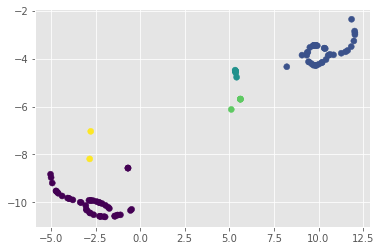

In [8]:
# Clustering and visualization of the 
X_embedded = TSNE(n_components=2).fit_transform(preds)
cluster = KMeans(n_clusters=5, random_state=0).fit(preds)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_)

In [9]:
# the predictions (distances) with all data pairs

pair = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        pair[i,j] = model.predict([x_train[i:i+1], x_train[j:j+1]])

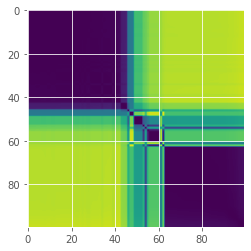

In [10]:
# sorting the clusters based on the distances to the first sample

plt.imshow(pair[np.argsort(pair[0]),:][:,np.argsort(pair[0])])

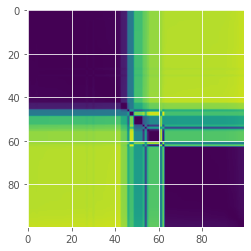

In [11]:
# sorting the clusters based on the distances to the second sample

plt.imshow(pair[np.argsort(pair[1]),:][:,np.argsort(pair[1])])

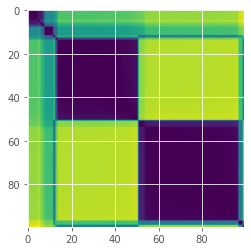

In [12]:
# sorting the clusters based on the distances to the third sample

plt.imshow(pair[np.argsort(pair[2]),:][:,np.argsort(pair[2])])

Text(0, 0.5, 'Amplitude')

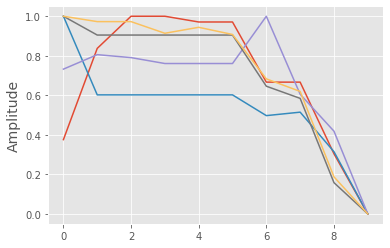

In [13]:
# Samples of the data most similar to the first sample data 

_ = plt.plot(x_train[np.argsort(pair[0])[:5]].squeeze().T)
plt.ylabel('Amplitude', fontsize=14)